# The Musk Effect on Crypto: A Data-Driven Analysis

In [6]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import os
from PIL import Image
from mplfinance.original_flavor import candlestick_ohlc
from wordcloud import WordCloud
import requests
from io import BytesIO
from bokeh.models import ColumnDataSource, TableColumn, DataTable
from bokeh.layouts import column
from bokeh.plotting import show
from bokeh.models import ColumnDataSource, Div
from bokeh.io import show
from bokeh.models.widgets import DataTable, TableColumn
from bokeh.layouts import column
import pandas as pd
import pandas as pd
from bokeh.models import ColumnDataSource, TableColumn, DataTable, Div
from bokeh.layouts import column
from bokeh.io import show, save

if not os.path.exists('out'):
    os.makedirs('out')

## Visualizations

### Interactive Tables Using Bokeh

In [7]:
def plot_interactive_table(df, title):
    page_title = Div(text=f'<h1>{title}</h1>')

    info_title = Div(text='<h2>Information</h2>')
    info_dict = {
        'Column': df.columns,
        'Count': df.count(),
        'Null Count': df.isnull().sum(),
        'Unique Count': df.nunique(),
        'Data Type': df.dtypes.astype(str)
    }
    info_df = pd.DataFrame(info_dict)
    info_source = ColumnDataSource(info_df)
    info_columns = [
        TableColumn(field='Column', title='Column'),
        TableColumn(field='Count', title='Count'),
        TableColumn(field='Null Count', title='Null Count'),
        TableColumn(field='Unique Count', title='Unique Count'),
        TableColumn(field='Data Type', title='Data Type')
    ]
    info_data_table = DataTable(source=info_source, columns=info_columns, height=25*(len(df.columns)+1))

    stats_title = Div(text='<h2>Descriptive Statistics</h2>')
    stats = df.describe().reset_index()
    stats_source = ColumnDataSource(stats)
    stats_columns = [TableColumn(field=col, title=col) for col in stats.columns]
    stats_data_table = DataTable(source=stats_source, columns=stats_columns, height=25*(len(stats)+1))

    layout = column(page_title, info_title, info_data_table, stats_title, stats_data_table)
    show(layout)
    save(layout, filename=f'out/{title.lower().replace(" ", "-")}.html')

### Trading Chart Using Matplotlib

In [8]:
def plot_trading_chart(df, title, start_date, end_date, time_period=None, tweets=None):
    filtered_df = df.set_index('Timestamp').loc[start_date:end_date]
    filtered_df = (
        filtered_df.resample('D')
        .agg({
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last',
            'Volume': 'sum',
        })
        .dropna()
    )

    filtered_df['Date'] = filtered_df.index.map(mdates.date2num)
    ohlc_data = filtered_df[['Date', 'Open', 'High', 'Low', 'Close']].reset_index(drop=True).values
    highest_value = filtered_df['High'].max()
    lowest_value = filtered_df['Low'].min()

    fig = plt.figure(figsize=(10, 6))
    gs = fig.add_gridspec(2, 1, height_ratios=[3, 1])
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])

    colorup = '#4CAF50'
    colordown = '#F44336'

    candlestick_ohlc(ax1, ohlc_data, width=0.5, colorup=colorup, colordown=colordown)
    ax1.grid(True, linestyle='-', alpha=0.1, color='black', linewidth=0.5)
    ax1.axhline(highest_value, color=colorup, linestyle='--', linewidth=2, label=f'Highest: {highest_value}')
    ax1.axhline(lowest_value, color=colordown, linestyle='--', linewidth=2, label=f'Lowest: {lowest_value}')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.xaxis_date()
    ax1.xaxis.set_major_locator(mdates.DayLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
    ax1.set_title(title)
    ax1.set_ylabel('Price (USD)')
    ax1.set_xlabel(time_period)
    ax1.legend()

    if tweets:
        for start_date, end_date in tweets:
            i = mdates.date2num(pd.to_datetime(start_date))
            j = mdates.date2num(pd.to_datetime(end_date))
            ax1.axvspan(i, j, color='#1DA1F2', alpha=0.1)

    for i, j in filtered_df.iterrows():
        if j['Close'] > j['Open']:
            color = colorup
        else:
            color = colordown
        ax2.bar(i, j['Volume'], color=color)

    ax2.grid(True, axis='y', linestyle='-', alpha=0.1, color='black', linewidth=0.5)
    ax2.set_ylabel('Volume')
    ax2.set_xlabel(time_period)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.xaxis.set_major_locator(mdates.DayLocator())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d'))

    plt.tight_layout()
    plt.savefig(f'out/{title.lower().replace(" ", "-")}.png')

### WordCloud Using Matplotlib

In [9]:
def plot_wordcloud(df, title, crypto_name=''):
    filtered_df = df[df['Tweet'].str.contains(crypto_name, case=False, na=False)]
    tweets = ' '.join(filtered_df['Tweet'].dropna())
    tweets = tweets.replace('BTC', 'Bitcoin').replace('DOGE', 'Doge')

    keywords_colors = {
        'Bitcoin': '#F7931A',
        'Doge': '#BA9F33',
        'Tesla': '#E82127',
        'SpaceX': '#004B87',
    }
    keyword_counts = {keyword: tweets.lower().count(keyword.lower()) for keyword in keywords_colors}
    word_frequencies = {}
    for word, count in keyword_counts.items():
        word_frequencies[word] = count * 100
    for word in re.findall(r'\w+', tweets):
        word_frequencies[word] = word_frequencies.get(word, 0) + 1

    url = 'https://raw.githubusercontent.com/robertovicario/uninsubria-DataVisualization-Project-Work/main/assets/img/twitter.png'
    response = requests.get(url)
    bg_img = Image.open(BytesIO(response.content)).convert('L')
    mask = np.array(bg_img)

    def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        if word in keywords_colors:
            return keywords_colors[word]
        else:
            return '#C0C0C0'

    wordcloud = WordCloud(background_color='white',
                        mask=mask,
                        max_words=10000,
                        color_func=color_func,
                        contour_color='#1DA1F2',
                        contour_width=2,
                        relative_scaling=0.5).generate_from_frequencies(word_frequencies)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.savefig(f'out/{title.lower().replace(" ", "-")}.png')

## EDA (Exploratory Data Anaysis)

In [10]:
btc_prices_2021 = pd.read_csv('data/btc_prices_2021.csv')
btc_prices_2024 = pd.read_csv('data/btc_prices_2024.csv')
doge_prices = pd.read_csv('data/doge_prices.csv')
musk_tweets = pd.read_csv('data/musk_tweets.csv')

### BTC Prices Dataset Overview

In [11]:
btc_prices = pd.concat([btc_prices_2021, btc_prices_2024], ignore_index=True)
plot_interactive_table(btc_prices, 'Bitcoin Prices Dataset Overview')

/var/folders/3n/vf15kv6n675_m6mzk8p8rfxr0000gn/T/ipykernel_68586/942376540.py:31: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  save(layout, filename=f'out/{title.lower().replace(" ", "-")}.html')
/var/folders/3n/vf15kv6n675_m6mzk8p8rfxr0000gn/T/ipykernel_68586/942376540.py:31: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  save(layout, filename=f'out/{title.lower().replace(" ", "-")}.html')


### DOGE Prices Dataset Overview

In [12]:
plot_interactive_table(doge_prices, 'Dogecoin Prices Dataset Overview')

/var/folders/3n/vf15kv6n675_m6mzk8p8rfxr0000gn/T/ipykernel_68586/942376540.py:31: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  save(layout, filename=f'out/{title.lower().replace(" ", "-")}.html')
/var/folders/3n/vf15kv6n675_m6mzk8p8rfxr0000gn/T/ipykernel_68586/942376540.py:31: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  save(layout, filename=f'out/{title.lower().replace(" ", "-")}.html')


### Musk Tweets Dataset Overview

In [13]:
plot_interactive_table(musk_tweets, 'Elon Musk Tweets Dataset Overview')

/var/folders/3n/vf15kv6n675_m6mzk8p8rfxr0000gn/T/ipykernel_68586/942376540.py:31: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  save(layout, filename=f'out/{title.lower().replace(" ", "-")}.html')
/var/folders/3n/vf15kv6n675_m6mzk8p8rfxr0000gn/T/ipykernel_68586/942376540.py:31: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  save(layout, filename=f'out/{title.lower().replace(" ", "-")}.html')


## Tesla Episode on Bitcoin (2021)

In [14]:
bitcoin_2021_df = pd.read_csv('data/btc_prices_2021.csv', parse_dates=['Timestamp'])
bitcoin_2024_df = pd.read_csv('data/btc_prices_2024.csv', parse_dates=['Timestamp'])

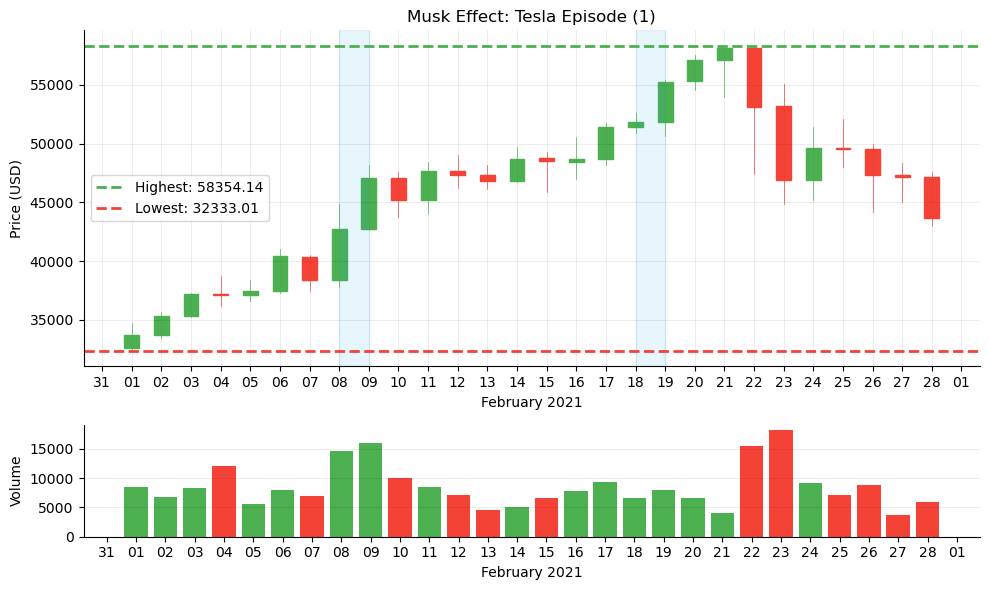

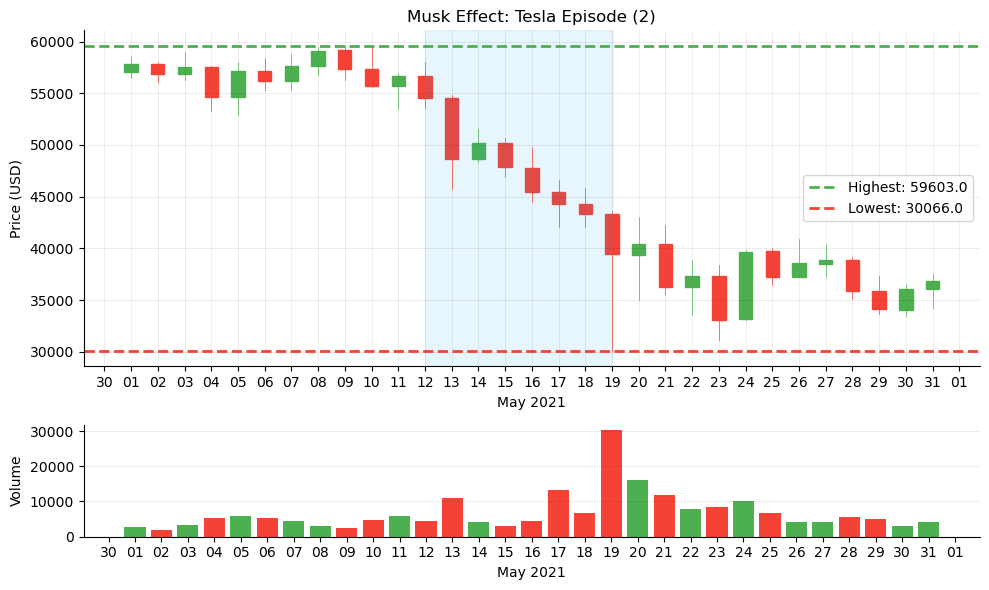

In [15]:
start_date = '2021-02-01'
end_date = '2021-02-28'
title = 'Musk Effect: Tesla Episode (1)'
time_period = 'February 2021'
tweets = [
    ('2021-02-08', '2021-02-09'),
    ('2021-02-18', '2021-02-19')
]
plot_trading_chart(df=bitcoin_2021_df,
                   title=title,
                   start_date=start_date,
                   end_date=end_date,
                   time_period=time_period,
                   tweets=tweets)

start_date = '2021-05-01'
end_date = '2021-05-31'
title = 'Musk Effect: Tesla Episode (2)'
time_period = 'May 2021'
tweets = [('2021-05-12', '2021-05-19')]
plot_trading_chart(df=bitcoin_2021_df,
                   title=title,
                   start_date=start_date,
                   end_date=end_date,
                   time_period=time_period,
                   tweets=tweets)

## Musk Tweets: An Overview

In [16]:
musk_tweets = pd.read_csv('data/musk_tweets.csv')

### Emerging Topics in Musk Tweets

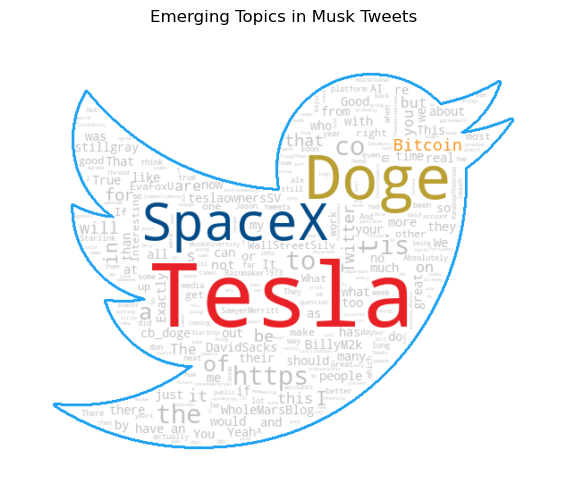

In [17]:
plot_wordcloud(musk_tweets, 'Emerging Topics in Musk Tweets')

### Exploring Topics in Musk Tweets by Crypto

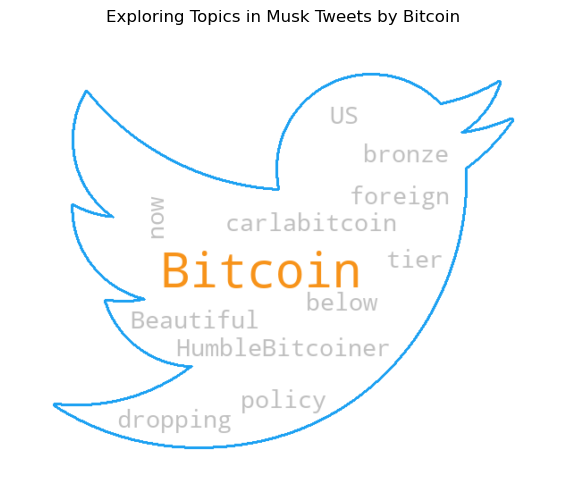

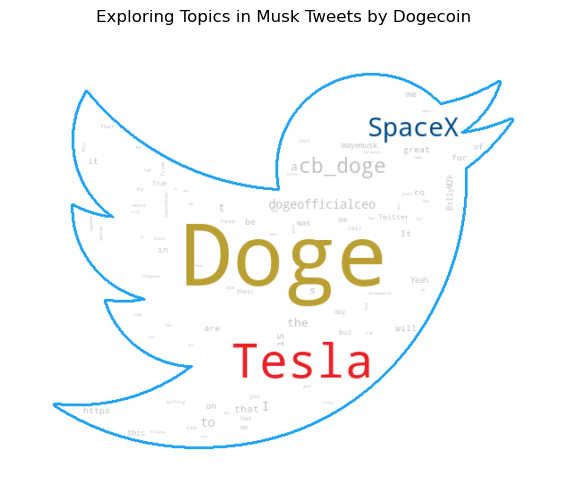

In [18]:
plot_wordcloud(musk_tweets, 'Exploring Topics in Musk Tweets by Bitcoin', 'Bitcoin')
plot_wordcloud(musk_tweets, 'Exploring Topics in Musk Tweets by Dogecoin', 'Doge')